# **Importing the Packages**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1465205244858451426
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16059727872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3993290627056668421
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
path = "/kaggle/input/pix2pixmap/maps/train/"
num_images = 1096

combined_images = sorted(glob(path + "*.jpg"))[:num_images]    
images = np.zeros(shape=(len(combined_images), 256, 256, 3))
masks = np.zeros(shape=(len(combined_images), 256, 256, 3))

for idx, path in enumerate(combined_images):

    combined_image = tf.cast(img_to_array(load_img(path)), tf.float32)
    
    image = combined_image[:,:600,:]
    mask = combined_image[:,600:,:]

    images[idx] = (tf.image.resize(image,(256,256)))/255
    masks[idx] = (tf.image.resize(mask,(256,256)))/255

In [5]:
len(combined_images)

1096

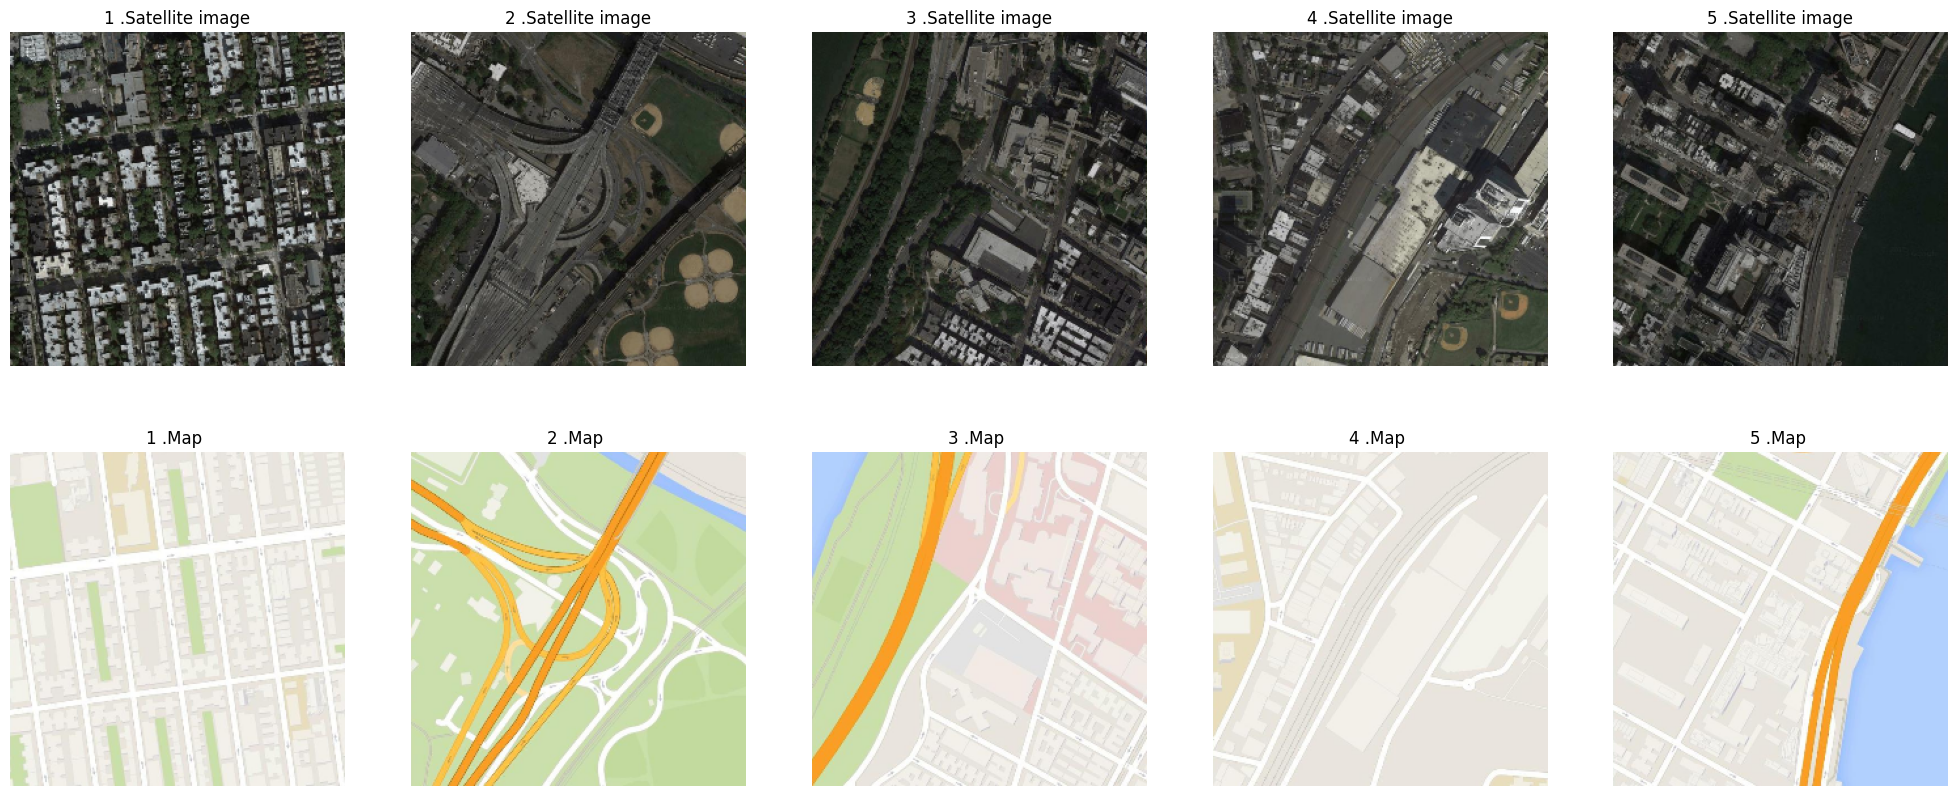

In [6]:
plt.figure(figsize=(25,10))
for i in range(1,6):
    idx = np.random.randint(1,1000)
    image, mask = images[idx], masks[idx]
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(str(i) + " .Satellite image")
    plt.axis("off")
    
    plt.subplot(2,5,i + 5)
    plt.imshow(mask)
    plt.title(str(i) + " .Map ")
    plt.axis("off")
plt.show()

# Generator of Pix2Pix GAN

In [4]:
def downscale(num_filters):
    block = Sequential()
    block.add(Conv2D(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    return block

def upscale(num_filters):
    block = Sequential()
    block.add(Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    block.add(LeakyReLU(alpha=0.2))
    block.add(BatchNormalization())
    block.add(ReLU())
    return block

def Generator():
    inputs = Input(shape=(256,256,3), name="InputLayer")

    encoder = [
        downscale(64),
        downscale(128),
        downscale(256),
        downscale(512),
        downscale(512),
        downscale(512),
        downscale(512),
    ]
    
    latent_space = downscale(512)

    decoder = [
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(512),
        upscale(256),
        upscale(128),
        upscale(64),
    ]
    
    x = inputs 
    skips = []
    for layer in encoder:
        x = layer(x)
        skips.append(x)
    
    x = latent_space(x)

    skips = reversed(skips)
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = concatenate([x, skip])
    
    initializer = RandomNormal(stddev=0.02, seed=42)
    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, kernel_initializer = initializer, activation = 'tanh', padding = 'same')

    outputs = outputs(x)

    generator = Model(inputs = inputs, outputs = outputs, name="Generator")
    return generator

# Discriminator of Pix2Pix GAN

In [5]:
def Discriminator():
    image = Input(shape = (256,256,3), name = "ImageInput")
    target = Input(shape = (256,256,3), name = "TargetInput")
    x = concatenate([image, target])

    x = downscale(64)(x)
    x = downscale(128)(x)
    x = downscale(512)(x)

    initializer = RandomNormal(stddev = 0.02, seed=42)
        
    x = Conv2D(512, kernel_size = 4, strides = 1, kernel_initializer = initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, kernel_size = 4, kernel_initializer = initializer)(x)

    discriminator = Model(inputs = [image, target], outputs = x, name = "Discriminator")

    return discriminator

# Function Definition of Generator Loss, Discriminator Loss and Training Step

In [6]:
gan_losses = []  # List to store generator losses
disc_losses = []

In [7]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def generator_loss(discriminator_generated, generated_output, target_image):
    gan_loss = adversarial_loss(tf.ones_like(discriminator_generated), discriminator_generated)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_output))
    total_loss = (100 * l1_loss) + gan_loss
    return total_loss, gan_loss, l1_loss

def discriminator_loss(discriminator_real_output, discriminator_generated_output):
    real_loss = adversarial_loss(tf.ones_like(discriminator_real_output), discriminator_real_output)
    fake_loss = adversarial_loss(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

def train_step(inputs, target):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_output = generator(inputs, training=True)
        
        discriminator_real_output = discriminator([inputs, target], training=True)
        discriminator_generated_output = discriminator([inputs, generated_output], training=True)
        
        generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generated_output, target)
        
        discriminator_Loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)
        
    generator_gradients = generator_tape.gradient(generator_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_gradients = discriminator_tape.gradient(discriminator_Loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return generator_total_loss, discriminator_Loss

In [8]:
def fit(data, epochs):
  for epoch in range(epochs):
    start = time.time()
    print("Current epoch: ", epoch+1)
    gan_loss=0
    disc_loss=0
    for image, mask in data:
        gan_loss,disc_loss = train_step(image, mask)
    print(f"Time taken to complete the epoch {epoch + 1} is {(time.time() - start):.2f} seconds \n")
    gan_losses.append(gan_loss)
    disc_losses.append(disc_loss)
    print("Generator loss is: ",gan_loss.numpy())
    print("Discrimator loss is: ",disc_loss.numpy())

In [11]:
sat_image, map_image = tf.cast(images, tf.float32), tf.cast(masks, tf.float32)
dataset = (sat_image,map_image)
data = tf.data.Dataset.from_tensor_slices(dataset).batch(32, drop_remainder=True)

In [12]:
generator = Generator()
discriminator = Discriminator()
Epochs=100

In [14]:
fit(data, Epochs)

Current epoch:  1
Time taken to complete the epoch 1 is 46.68 seconds 

Generator loss is:  31.82999
Discrimator loss is:  0.9292792
Current epoch:  2
Time taken to complete the epoch 2 is 24.73 seconds 

Generator loss is:  10.595113
Discrimator loss is:  0.87568814
Current epoch:  3
Time taken to complete the epoch 3 is 24.74 seconds 

Generator loss is:  8.60956
Discrimator loss is:  0.513111
Current epoch:  4
Time taken to complete the epoch 4 is 24.77 seconds 

Generator loss is:  9.094833
Discrimator loss is:  0.9653756
Current epoch:  5
Time taken to complete the epoch 5 is 24.80 seconds 

Generator loss is:  8.042306
Discrimator loss is:  0.7411798
Current epoch:  6
Time taken to complete the epoch 6 is 24.81 seconds 

Generator loss is:  8.039615
Discrimator loss is:  1.6754749
Current epoch:  7
Time taken to complete the epoch 7 is 24.77 seconds 

Generator loss is:  6.5593596
Discrimator loss is:  1.1705536
Current epoch:  8
Time taken to complete the epoch 8 is 24.79 second

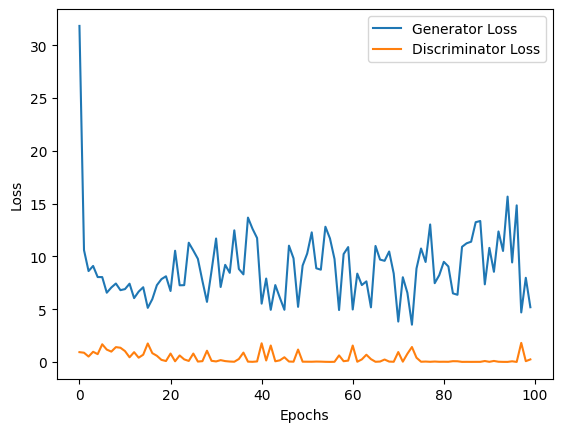

In [15]:
plt.plot(range(Epochs), gan_losses, label="Generator Loss")
plt.plot(range(Epochs), disc_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
generator.load_weights('/kaggle/input/pix2pix-model/model_GAN_Pix2Pix_100.h5')

In [25]:
path_val = "/kaggle/input/pix2pixmap/maps/val/"
num_images_val = 1098

combined_images_val = sorted(glob(path_val + "*.jpg"))[:num_images_val]    
images_val = np.zeros(shape=(len(combined_images_val), 256, 256, 3))
masks_val = np.zeros(shape=(len(combined_images_val), 256, 256, 3))

for idx, path_val in enumerate(combined_images_val):

    combined_image_val = tf.cast(img_to_array(load_img(path_val)), tf.float32)
    
    image_val = combined_image_val[:,:600,:]
    mask_val = combined_image_val[:,600:,:]

    images_val[idx] = (tf.image.resize(image_val,(256,256)))/255
    masks_val[idx] = (tf.image.resize(mask_val,(256,256)))/255

In [26]:
len(images_val)

1098

In [27]:
actual = []
fake = []

In [28]:
def show_predictions(num_samples):
    for i in range(num_samples):
        idx = np.random.randint(images.shape[0])
        image, mask = images_val[idx], masks_val[idx]
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]

        plt.figure(figsize=(10,8))
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Satellite Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Map Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(i + 1))
        plt.axis('off')
        
        plt.show()

In [29]:
def predictions():
    for i in range(0,1098):
        #idx = np.random.randint(images.shape[0])
        image, mask = images_val[i], masks_val[i]
        actual.append(mask)
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        fake.append(predicted)

1/1 [==============================] - 0s 22ms/step


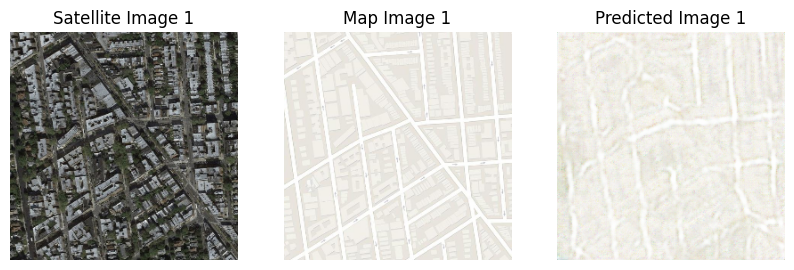

1/1 [==============================] - 0s 20ms/step


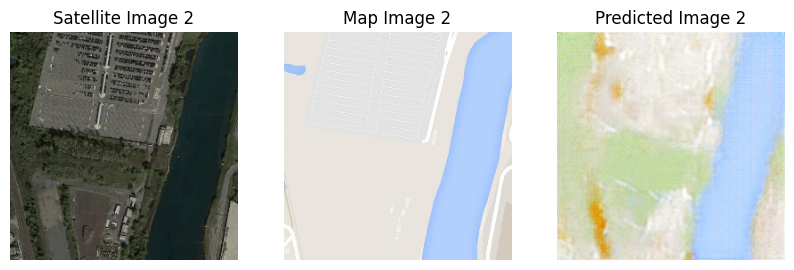

1/1 [==============================] - 0s 22ms/step


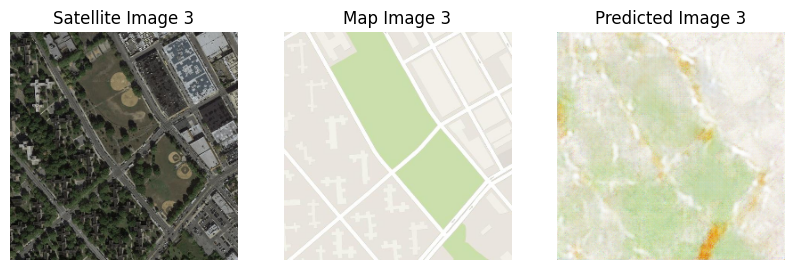

1/1 [==============================] - 0s 19ms/step


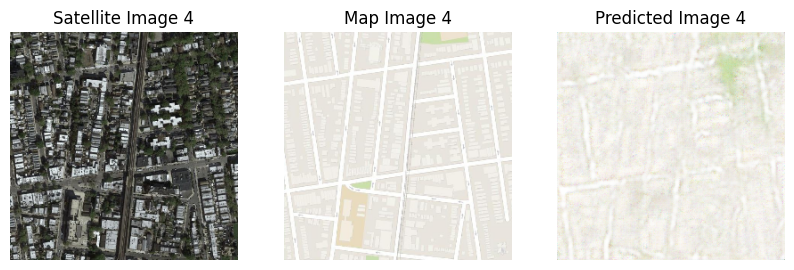

In [30]:
show_predictions(4)

In [31]:
#filename2 = 'model_GAN_Pix2Pix_100.h5'
#generator.save(filename2)

In [32]:
#generator.load_weights('/kaggle/input/testing-model-load/model_GAN_Pix2Pix.h5')

In [33]:
predictions()

1/1 [==============================] - 0s 29ms/step


In [34]:
#import numpy as np
from keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from scipy.linalg import sqrtm
from numpy import iscomplexobj
from tensorflow.keras.models import Model

# Load ResNet50 model without the final classification layer
base_model = ResNet50(weights='imagenet', input_shape=(256, 256, 3), include_top=False, pooling='avg')

# Function to preprocess images for ResNet50
def preprocess_images(images):
    images = np.array([image.img_to_array(img) for img in images])
    images = tf.keras.applications.resnet50.preprocess_input(images)
    return images

# Function to calculate FID
def calculate_fid(images1, images2):
    # Preprocess images
    images1 = preprocess_images(images1)
    images2 = preprocess_images(images2)

    # Generate feature representations
    features1 = base_model.predict(images1)
    features2 = base_model.predict(images2)

    # Calculate mean and covariance statistics
    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)

    # Calculate FID
    sum_squared_diff = np.sum((mu1 - mu2)**2)
    cov_mean_sqrt = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real
    fid = sum_squared_diff + np.trace(sigma1 + sigma2 - 2.0 * cov_mean_sqrt)

    return fid

# Example usage
# images_set1 and images_set2 should be numpy arrays with images of shape (num_images, 256, 256, 3)
print(len(actual))
print(len(fake))
fid_score = calculate_fid(actual, fake)
print(f"FID Score: {fid_score}")


94765736/94765736 [==============================] - 3s 0us/step
1098
1098
35/35 [==============================] - 2s 59ms/step
FID Score: 0.15536620934694587
